# Directional Displacement of Forecast Objects 

This notebook demostrates how to create a displacement graph of forecast/observation pairs using MODE output. This graph is similar to that of the one seen in figure 14 of Duda & Turner 2021 paper (https://journals.ametsoc.org/view/journals/wefo/36/3/WAF-D-20-0203.1.xml#fig14). 

In [1]:
import xarray as xr
import glob
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import gaussian_kde

## Subsetting MODE Output Data

In [2]:
#grab different subsets of files.
output_all = glob.glob(f'/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_output/mode_output/*obj.txt')
output_40 = glob.glob(f'/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_output/mode_output/*T1_obj.txt')
output_35 = glob.glob(f'/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_output/mode_output/*T2_obj.txt')
output_30 = glob.glob(f'/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_output/mode_output/*T3_obj.txt')
output_25 = glob.glob(f'/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_output/mode_output/*T4_obj.txt')


In [3]:
#arrays for x and y displacement values.
xs = []
ys = []

for ds in output_40:
    
    #grab the output MODE object text datafile.
    obj = pd.read_csv(ds, delim_whitespace=True)
    
    #subset distance and centriods of shape objects
    dist = obj.CENTROID_DIST.values
    centx = obj.CENTROID_X.values
    centy = obj.CENTROID_Y.values

    #subset identifiers of objects
    obj_id = obj.OBJECT_ID.values
    obj_cat = obj.OBJECT_CAT.values

    #find where there are nan-vaules. Identfies rows with paired or unpaired objects.
    Con_points = np.argwhere(np.isnan(dist))
    dist_points = np.argwhere(np.isnan(centx))
    
    #iterate through paired objects.
    for i in dist_points:
        fstring = obj_id[i[0]][0:4]
        ostring = obj_id[i[0]][5:9]

        cfstring = obj_cat[i[0]][0:5]
        costring = obj_cat[i[0]][6:11]


        #find where the paired objects are unpaired in the datafile.
        for_loc = np.where((cfstring == obj_cat) & (fstring == obj_id))
        obs_loc = np.where((costring == obj_cat) & (ostring == obj_id))

        #grab centriod values for the objects.
        obs_x = centx[obs_loc]
        obs_y = centy[obs_loc]
        for_x = centx[for_loc]
        for_y = centy[for_loc]

        #calculate the displacement value between paired forecast and observation objects.
        x_side = for_x - obs_x
        y_side = for_y - obs_y


        #see if array is not empty and append values to their appropiate array.
        if obs_x.size > 0:
            xs.append(x_side[0])
            ys.append(y_side[0])

## Create Displacement Graph

In [4]:
#Extract x and y
x=xs
y=ys

#Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

#Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]


In [5]:
#create a smoothing contour of the displacement values.
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

In [6]:
#find average and median values
x_avg = np.average(xs)
y_avg = np.average(ys)

x_med = np.median(xs)
y_med = np.median(ys)

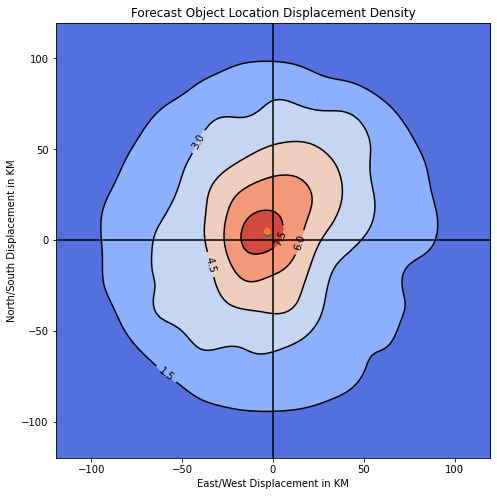

In [7]:
#Create the graph
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.scatter(x_avg, y_avg)
ax.scatter(x_med, y_med)
ax.set_xlabel('East/West Displacement in KM')
ax.set_ylabel('North/South Displacement in KM')
plt.title('Forecast Object Location Displacement Density')
plt.axvline(x = 0, color = 'black')
plt.axhline(y = 0, color = 'black')